In [ ]:
pip uninstall tensorflow tensorflow-addons

Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.17.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
Y

  Successfully uninstalled tensorflow-2.17.1
Found existing installation: tensorflow-addons 0.23.0
Uninstalling tensorflow-addons-0.23.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/_foo.cpython-310-x86_64-linux-gnu.so
    /usr/local/lib/python3.10/dist-packages/tensorflow_addons-0.23.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow_addons/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-addons-0.23.0


In [ ]:
pip install tensorflow==2.15.0 tensorflow-addons==0.23.0

Epoch 1/20
235/235 [==============================] - 106s 443ms/step - loss: 1.5458 - val_loss: 1.7565
Epoch 2/20
235/235 [==============================] - 101s 431ms/step - loss: 1.0567 - val_loss: 1.7619
Epoch 3/20
235/235 [==============================] - 108s 459ms/step - loss: 1.0072 - val_loss: 1.7617
Epoch 4/20
235/235 [==============================] - 112s 476ms/step - loss: 0.9759 - val_loss: 1.7187
Epoch 5/20
235/235 [==============================] - 102s 434ms/step - loss: 0.9520 - val_loss: 1.8073
Epoch 6/20
235/235 [==============================] - 104s 444ms/step - loss: 0.9350 - val_loss: 1.8293
Epoch 7/20
235/235 [==============================] - 99s 422ms/step - loss: 0.9134 - val_loss: 1.7826
Epoch 8/20
235/235 [==============================] - 103s 436ms/step - loss: 0.8963 - val_loss: 1.8408
Epoch 9/20
235/235 [==============================] - 102s 436ms/step - loss: 0.8796 - val_loss: 1.8602
Epoch 10/20
235/235 [==============================] - 108s 461ms

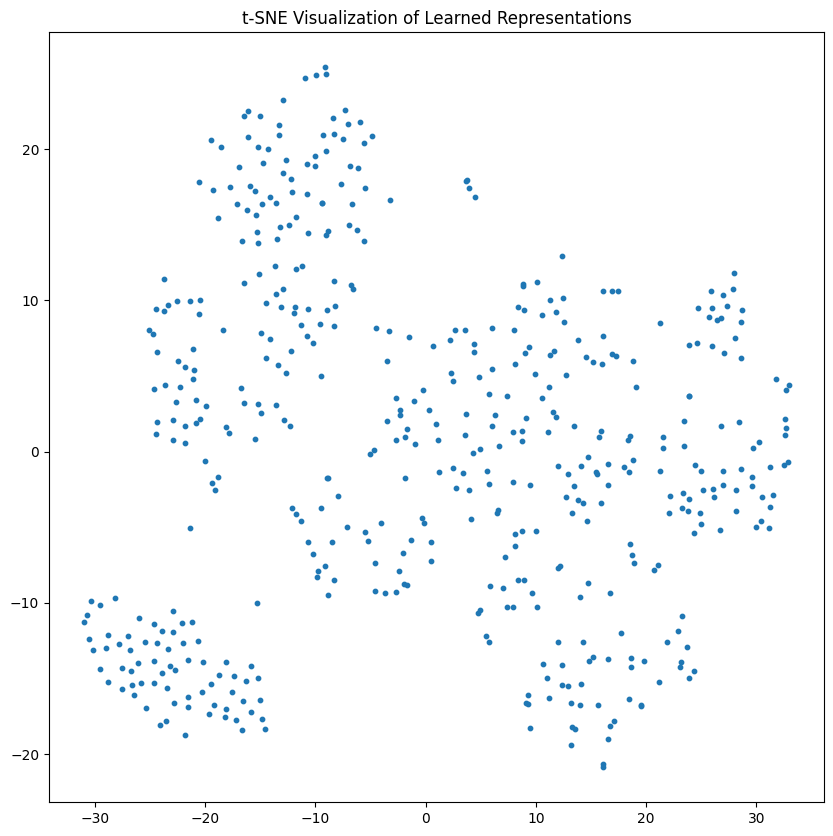

313/313 [==============================] - 4s 14ms/step


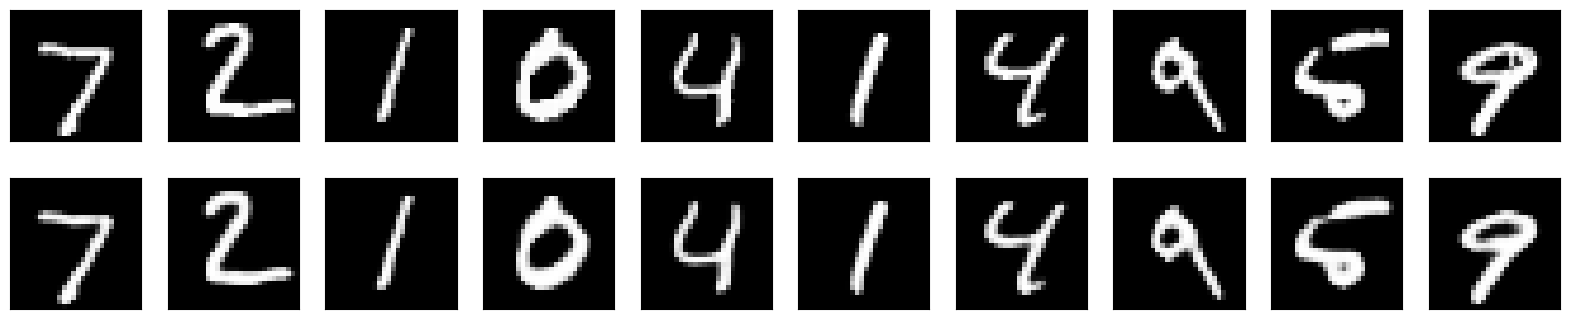

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

# 1. Data Preparation
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Data augmentation function
def augment(image, max_rotation=20): # Increase max rotation angle
    angle = np.random.uniform(-max_rotation, max_rotation)
    angle_rad = angle * np.pi / 180.0
    image = tfa.image.rotate(image, angle_rad)
    image = tf.image.random_crop(image, size=[28, 28, 1]) # Random crop
    if np.random.rand() > 0.5:  # Random flip with 50% probability
      image = tf.image.flip_left_right(image)
    return image

# 2. Model (Autoencoder)
input_img = Input(shape=(28, 28, 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) # Increase filters to 32
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

# Separate encoder model for representation learning
encoder = Model(input_img, encoded)

# 3. Contrastive Loss (InfoNCE)

def contrastive_loss(y_true, y_pred):
    # Normalize representations
    representations = tf.math.l2_normalize(y_pred, axis=1)
    similarity_matrix = tf.matmul(representations, representations, transpose_b=True)

    batch_size = tf.shape(similarity_matrix)[0] // 2  # Adjust for augmented views

    # Create positive mask
    mask_positives = tf.eye(batch_size)
    mask_positives = tf.concat([mask_positives, mask_positives], axis=0)
    mask_positives = tf.concat([mask_positives, mask_positives], axis=1)

    # Explicitly cast mask_positives to boolean
    mask_positives = tf.cast(mask_positives, dtype=tf.bool)

    # Create negative mask
    mask_negatives = tf.logical_not(mask_positives)
    mask_self = tf.eye(2 * batch_size, dtype=tf.bool)
    mask_negatives = tf.logical_and(mask_negatives, tf.logical_not(mask_self))

    # Extract positives and negatives
    positives = tf.boolean_mask(similarity_matrix, mask_positives)
    negatives = tf.boolean_mask(similarity_matrix, mask_negatives)

    # Compute the number of negatives per positive
    num_negatives = tf.shape(negatives)[0] // tf.shape(positives)[0]

    # Reshape for logits
    positives = tf.reshape(positives, [-1, 1])
    negatives = tf.reshape(negatives, [-1, num_negatives])

    # Concatenate positives and negatives
    logits = tf.concat([positives, negatives], axis=1) / temperature

    # Create labels (all positives are at index 0)
    labels = tf.zeros(tf.shape(positives)[0], dtype=tf.int32)

    # Compute loss
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
    return tf.reduce_mean(loss)

# Custom layer to generate augmented views and concatenate them
class AugmentationLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        augmented_view = tf.map_fn(augment, inputs)
        return tf.concat([inputs, augmented_view], axis=0)

    def compute_output_shape(self, input_shape):
        return (input_shape[0] * 2, input_shape[1], input_shape[2], input_shape[3])

augmentation_layer = AugmentationLayer()
augmented_images = augmentation_layer(input_img)

# Create representations for augmented views
encoded_augmented = encoder(augmented_images)
# Flatten the encoded representations
encoded_augmented_flat = tf.keras.layers.Flatten()(encoded_augmented)

# Create a model that outputs the flattened encoded representations
contrastive_model = Model(input_img, encoded_augmented_flat)

# Compile and train the contrastive model
contrastive_model.compile(optimizer='adam', loss=contrastive_loss)

contrastive_model.fit(x_train, x_train,
                    epochs=20, # Reduced epochs
                    batch_size=256,
                    shuffle=True,
                    validation_data=(x_test, x_test))

# Compile and train the autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy') # or 'mse'
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

# 4. Evaluate Representations (Example: Visualization)
# Encode some test images
encoded_imgs = encoder.predict(x_test)
encoded_imgs = encoded_imgs.reshape((encoded_imgs.shape[0], -1))

# Use t-SNE for visualization (optional)
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
encoded_imgs_tsne = tsne.fit_transform(encoded_imgs[:500])  # Use a subset for t-SNE

# Plot t-SNE results
plt.figure(figsize=(10, 10))
plt.scatter(encoded_imgs_tsne[:, 0], encoded_imgs_tsne[:, 1], s=10)
plt.title('t-SNE Visualization of Learned Representations')
plt.show()

# 5. Evaluate Reconstruction (Optional)
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()